In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import helper
import metrics
import _init_paths
import torch
import torch.utils.data
from opts import opts
#from lib.models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
#from trains.train_factory import train_factory
from pytorch_unet_center_wh import train_model
import unet_models
import os,sys
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import helper
#import simulation
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
import time
import copy
from models.data_parallel import DataParallel
import numpy as np
import torch
import metrics
from metrics import MetricsCollection
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
#from test_model import test
from scipy.ndimage.measurements import label
import shutil
from pycocotools.coco import COCO
import models


In [2]:
class opts(object):
  def __init__(self):
    self.seed = 327
    self.dataset = 'pascal'
    self.task = 'ctdet'
    self.device = 'cuda'
    self.shape_param = ''
    self.shape_param_value = ''
    self.data_dir = '../data'
    self.batch_size = 20
    self.master_batch_size = -1
    self.no_color_aug = True   # ???
    self.num_workers = 8
    self.keep_res = False
    #self.pad = 31
    
    # train data augmentation 
    self.not_rand_crop = True
    self.scale = 0 # 0.4  no effect
    self.shift = 0 # 0.1  no effect
    self.flip = 0  # 0.5  no effect
    self.down_ratio = 1
    #self.mse_loss = True

    #self.gpus_str = '0'
    self.input_res = -1
    self.input_h = 128#-1
    self.input_w = 128#-1
    #self.cat_spec_wh = True
    #self.not_reg_offset = True
    #self.reg_offset = not self.not_reg_offset
    
    self.gpus = '0'
    
    
    
    #self.debug_dir = '/home/ali/CenterNet/src/experimets_log'
    #self.trainval = True
    self.test_scales = '1'
    self.exp_id = 'default'
    #self.debug = 0
    #self.debugger_theme = 'white'
    self.fix_res = True
    self.flip_test =True
    
    self.resume = False
    self.last_model = ''
    self.checkpoint_interval = 20
    self.epochs = 100
    self.start_epoch = 0
    
    self.gamma = 0    # for focal loss
    self.bb_size= 1
  def update(self):
    self.log_dir = f'./experimets_log/{self.dataset}'
    self.last_model = f'./checkpoints/{self.dataset}/model_last_800.pth'
    
    #self.root_dir = os.path.join(os.path.dirname(__file__), '..', '..')
    #self.data_dir = os.path.join(self.root_dir, 'data')


In [3]:
# old stuff
def train_model(model, optimizer, lr_scheduler, data_loader, device, max_epochs): #loaders
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False
    earlystop_patience = 50

    epoch_metrics = MetricsCollection()
    
    log_file = os.path.join(opt.log_dir, f'log_{opt.dataset}.txt')
    f_mode = {True:'a', False: 'wt'}

    for epoch in range(opt.start_epoch, max_epochs):
        torch.cuda.empty_cache()
        print('Epoch {}/{}'.format(epoch, max_epochs - 1))
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode        # Each epoch has a training and validation phase

            batch_metrics = MetricsCollection()

            pbar = tqdm(data_loader, total=len(data_loader), desc="Epoch {} {}".format(epoch, phase), ncols=0)
            for _, (img_id, batch) in enumerate(pbar):            
                for k in batch:
                    if k != 'meta':
                        batch[k] = batch[k].to(device=device, non_blocking=True) 
                inputs,class_masks,center_masks,width_masks,height_masks = batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats
                
                output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
                loss = losses['loss']
                loss = loss.mean()
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                for k, v in losses.items():
                    batch_metrics.add(phase, k, v.mean().item())
                    
                pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})                    
                    
            output_str= ''
            for key, meter in batch_metrics[phase].items():
                epoch_metrics.add(phase, key, meter.avg)
                if phase=='train':
                    output_str = output_str + '{}_{}'.format(phase, key) + ':' + str(meter.avg) + ' ' 
            print(output_str)

            # logger -- must be changed to logger envetually 
            with open(log_file, f_mode[os.path.exists(log_file)]) as log:
                    log.write(output_str+ '\n')
    
                    
            if  phase == 'val': # (epoch% 10== 0 and epoch > 0): # phase == 'val' and
                model.eval()
                # monitor the val metrics
                best_epoch_index = epoch_metrics['val']['loss'].best()[1]
                #print(best_epoch_index, '-', epoch - opt.start_epoch)
                if best_epoch_index == epoch - opt.start_epoch: #epoch:
                    has_waited = 1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving the best model state dict")
                else:
                    if has_waited >= earlystop_patience:
                        print("** Early stop in training: {} waits **".format(has_waited))
                        stop_training = True

                    has_waited += 1
                if type(lr_scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                    lr_scheduler.step(epoch_metrics['val']['loss'].value)
                else:
                    lr_scheduler.step()
                    
            if epoch % opt.checkpoint_interval == 0 and epoch > 0 : #and epoch > 0
                    save_checkpoint({
                    'epoch': epoch + 1,
                    #'arch': args.arch,
                    'state_dict': model.state_dict(),
                    #'best_prec1': best_prec1,
                    'optimizer' : optimizer.state_dict(),
                        }, 
                            False, f'./checkpoints/{opt.dataset}/model_last_{epoch}.pth')
                
                    #model.load_state_dict(best_model_wts)
                    #torch.save(model.state_dict(), f'./checkpoints/model_last_{epoch}.pth')              

        #print()  # end of epoch
        if stop_training:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    #load best model weights
    model.load_state_dict(best_model_wts)
    save_checkpoint({
            'epoch': epoch + 1,
            #'arch': args.arch,
            'state_dict': model.state_dict(),
            #'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, True)
    
    #torch.save(model.state_dict(), './checkpoints/model_last.pth')    
    #torch.save(model, './checkpoints/model_last.pth')
    print ('New model saved!')
    return model



In [4]:
def train_model(model, optimizer, lr_scheduler, train_loader, val_loader, device, max_epochs): #loaders
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False
    earlystop_patience = 500

    epoch_metrics = MetricsCollection()
    
    log_file = os.path.join(opt.log_dir, f'log_{opt.dataset}.txt')
    f_mode = {True:'a', False: 'wt'}

    for epoch in range(opt.start_epoch, max_epochs):
        torch.cuda.empty_cache()
        print('Epoch {}/{}'.format(epoch, max_epochs - 1))

        batch_metrics = MetricsCollection()
        
        
        # TRAININING --------------------------------------------------------------
        phase = 'train'
        model.train()  # Set model to training mode
        #pbar = tqdm(train_loader, total=len(train_loader), desc="Epoch {} {}".format(epoch, phase), ncols=0)
        for _, (img_id, batch) in enumerate(train_loader):            
            #count_non_zero = 0
            for k in batch:
                if k != 'meta':
                    batch[k] = batch[k].to(device=device, non_blocking=True) 
            inputs,class_masks,center_masks,width_masks,height_masks = batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats
            #for i in range (20):
                #if (class_masks[i].max()==1):
                    #count_non_zero+=1
            #print (count_non_zero)
            output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
            loss = losses['loss']
            loss = loss.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for k, v in losses.items():
                batch_metrics.add(phase, k, v.mean().item())

            #pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})                    

        output_str= ''
        for key, meter in batch_metrics[phase].items():
            epoch_metrics.add(phase, key, meter.avg)
            if phase=='train':
                output_str = output_str + '{}_{}'.format(phase, key) + ':' + str(meter.avg) + ' ' 
        print(output_str)

        # logger -- must be changed to logger envetually 
        with open(log_file, f_mode[os.path.exists(log_file)]) as log:
                log.write(output_str+ '\n')
    

        # VALIDATION --------------------------------------------------------------
        phase = 'val'
        model.eval()
        
        #pbar = tqdm(val_loader, total=len(val_loader), desc="Epoch {} {}".format(epoch, phase), ncols=0) # val_loader
        for _, (img_id, batch) in enumerate(val_loader):            
            for k in batch:
                if k != 'meta':
                    batch[k] = batch[k].to(device=device, non_blocking=True) 
            inputs,class_masks,center_masks,width_masks,height_masks = batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats

            output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
            loss = losses['loss']
            loss = loss.mean()

            for k, v in losses.items():
                batch_metrics.add(phase, k, v.mean().item())
                
            #pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})                    
        
        for key, meter in batch_metrics[phase].items():
            epoch_metrics.add(phase, key, meter.avg)
        
        # monitor the val metrics
        best_epoch_index = epoch_metrics['val']['loss'].best()[1]
        #print(best_epoch_index, '-', epoch - opt.start_epoch)
        if best_epoch_index == epoch - opt.start_epoch: #epoch:
            has_waited = 1
            best_model_wts = copy.deepcopy(model.state_dict())
            print("Saving the best model state dict")
        else:
            if has_waited >= earlystop_patience:
                print("** Early stop in training: {} waits **".format(has_waited))
                stop_training = True

            has_waited += 1
        if type(lr_scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
            lr_scheduler.step(epoch_metrics['val']['loss'].value)
        else:
            lr_scheduler.step()

            
        # SAVING --------------------------------------------------------------
        if epoch % opt.checkpoint_interval == 0 and epoch > 0 : #and epoch > 0
                save_checkpoint({
                'epoch': epoch + 1,
                #'arch': args.arch,
                'state_dict': model.state_dict(),
                #'best_prec1': best_prec1,
                'optimizer' : optimizer.state_dict(),
                    }, 
                        False, f'./checkpoints/{opt.dataset}/model_last_{epoch}.pth')

                #model.load_state_dict(best_model_wts)
                #torch.save(model.state_dict(), f'./checkpoints/model_last_{epoch}.pth')              

        if stop_training:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
# END OF EPOCH --------------------------------------------------------------
    
    
    

    #load best model weights
    model.load_state_dict(best_model_wts)
    save_checkpoint({
            'epoch': epoch + 1,
            #'arch': args.arch,
            'state_dict': model.state_dict(),
            #'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, True)
    
    #torch.save(model.state_dict(), './checkpoints/model_last.pth')    
    #torch.save(model, './checkpoints/model_last.pth')
    print ('New model saved!')
    return model


In [5]:

def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, f'./checkpoints/{opt.dataset}/model_best_x.pth')

In [6]:


# def set_device(gpus, chunk_sizes, device, model, optimizer):
#     if len(gpus) > 1:
#       self.model_with_loss = DataParallel(
#         self.model_with_loss, device_ids=gpus, 
#         chunk_sizes=chunk_sizes).to(device)
#     else:
#       self.model_with_loss = self.model_with_loss.to(device)
    
#     for state in optimizer.state.values():
#       for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#           state[k] = v.to(device=device, non_blocking=True)

In [7]:

def main():
  
  opt.gpus = [int(gpu) for gpu in opt.gpus.split(',')]
  opt.gpus = [i for i in range(len(opt.gpus))] if opt.gpus[0] >=0 else [-1]
  
  if opt.master_batch_size == -1:
    opt.master_batch_size = opt.batch_size // len(opt.gpus)
  rest_batch_size = (opt.batch_size - opt.master_batch_size)
  opt.chunk_sizes = [opt.master_batch_size]
  for i in range(len(opt.gpus) - 1):
    slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
    if i < rest_batch_size % (len(opt.gpus) - 1):
      slave_chunk_size += 1
    opt.chunk_sizes.append(slave_chunk_size)  
  
  device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')  
  #set_device(opt.gpus, opt.chunk_sizes, device)      
  torch.manual_seed(opt.seed)
  
  Dataset = get_dataset(opt.dataset, opt.task)
  
  val_loader = torch.utils.data.DataLoader(
     Dataset(opt, 'train'), 
     batch_size=1, 
     shuffle=False,
     num_workers=1,
     pin_memory=True)


  train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=False,
      drop_last=True
  )
  #Mehdi
  ###############

  #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_class = Dataset.num_classes #6
  print (num_class)
  lr_factor = 0.1
  lr_patience = 1
  lr = 1e-4
  if(len (opt.gpus)>1):
        modelunet= DataParallel(
        unet_models.WidthHeightUNet(num_class, opt.gamma), device_ids=opt.gpus, 
        chunk_sizes=opt.chunk_sizes).to(device)
        
  else:
        modelunet = unet_models.WidthHeightUNet(num_class, opt.gamma).to(device)

  optimizer = torch.optim.Adam(modelunet.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            factor=lr_factor,
                                                          patience=lr_patience,
                                                            verbose=True)
  for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = v.to(device=device, non_blocking=True)
        
  if opt.resume:
        if os.path.isfile(opt.last_model):
            print("=> loading checkpoint '{}'".format(opt.last_model))
            checkpoint = torch.load(opt.last_model)
            opt.start_epoch = checkpoint['epoch']
            #best_prec1 = checkpoint['best_prec1']
            modelunet.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(opt.last_model, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(opt.resume))    
   # modelunet.load_state_dict(torch.load(opt.last_model))
        
  model = train_model(modelunet, optimizer, lr_scheduler, train_loader,val_loader, device, max_epochs = opt.epochs)
  return model  

In [8]:
opt = opts()
opt.dataset = 'shape'
opt.epochs =  1000
opt.gamma = 0 # focal loss
opt.resume = True
opt.checkpoint_interval = 10
opt.scale =0#0.1#2 # no effect
opt.shift = 0#0.025#2# no effect
opt.flip =0#1# 0.5  
opt.update()
trained_model = main()

==> initializing shapes train data.
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Loaded train 5000 samples
==> initializing shapes train data.
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Loaded train 5000 samples
5


KeyboardInterrupt: 

In [9]:
m = torch.load(f'./checkpoints/{opt.dataset}/model_last_810.pth') #75
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelunet = unet_models.WidthHeightUNet(5,0).to(device)  #num_class   

In [10]:
import torch
print (torch.__version__)

0.4.1.post2


In [11]:
opt.dataset

'shape'

In [15]:

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        
        return self.conv(input, weight=self.weight, groups=self.groups)

NameError: name 'nn' is not defined

In [16]:
modelunet.load_state_dict(m['state_dict'])


In [17]:

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    #inp = (inp * 255).astype(np.uint8) 
    
    return inp

In [18]:
#trained_model = torch.load('./checkpoints/model_best.pth')
#trained_model=modelunet. ['state_dict'][0]

import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 5
n_class= 5
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)

model= modelunet
    
model.eval()   # Set model to evaluate mode


==> initializing shapes train data.
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loaded train 5000 samples


WidthHeightUNet(
  (base_model): ResNetUNet(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

[(93, 51, 25, 26)]
[(93, 51, 1, 1)]
[]
[]
[(85, 20, 24, 22)]
[(85, 20, 1, 1)]
[]
[]
[(49, 61, 34, 59)]
[(49, 61, 1, 1)]
3


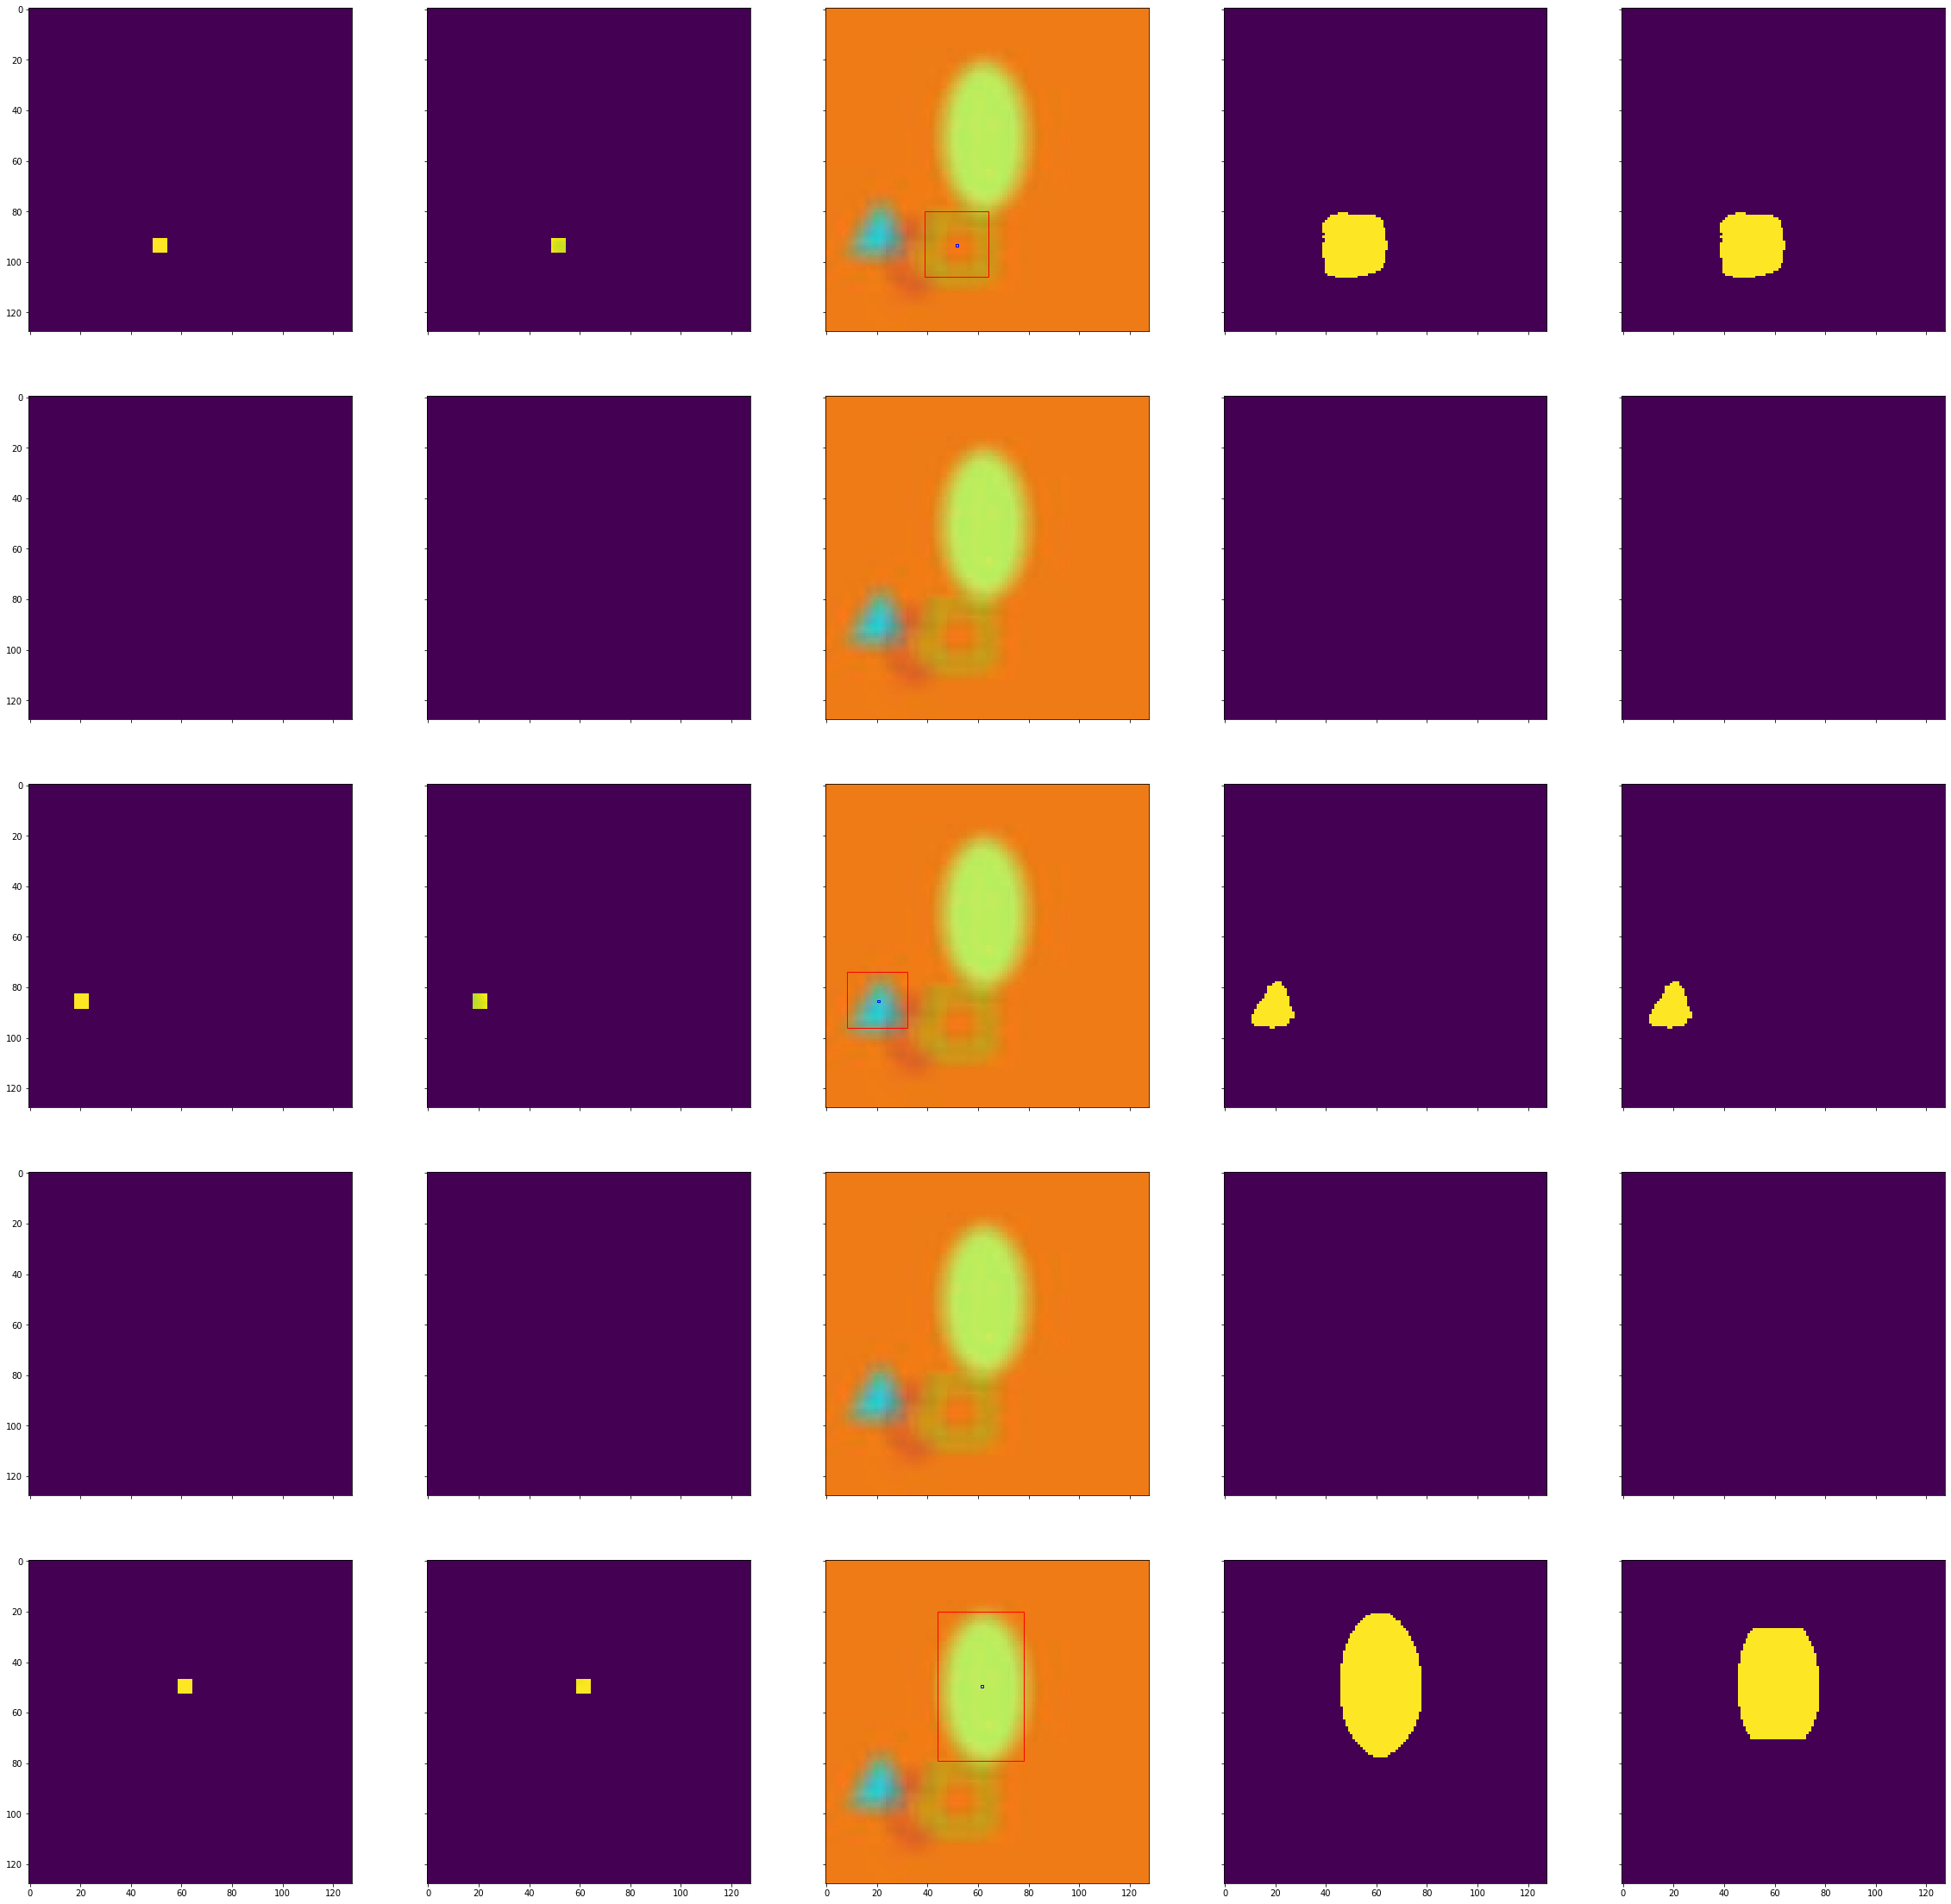

In [77]:

#test_dataset = SimDataset(1, n_class, transform = trans)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        
#batch  = next(iter(val_loader))

img_id, batch = next(iter (val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
pred = pred[0]



#inputs = inputs.to(device)
# labels_mask = labels_mask.to(device)
# labels_center = labels_center.to(device)



# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x)/255 for x in inputs.cpu()]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_mask]

# Map each channel (i.e. class) to each color
target_centers_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_center]

for i in [pred]:
    pred_masks = i['class_masks'].data.cpu().numpy()
    pred_centers = i['center_masks'].data.cpu().numpy()
    pred_widths = i['width_masks'].data.cpu().numpy()
    pred_heights = i['height_masks'].data.cpu().numpy()

    mask = pred_centers.copy() 
    mask[mask<0]=0
    mask[mask>0]=1
    
    #import pdb; pdb.set_trace()
    #pred_masks_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_masks]
    #pred_centers_rgb = [helper.masks_to_colorimg(x, n_class) for x in mask] # pred_centers
    #pred_widths_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_widths * mask]
    #pred_heights_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_heights * mask]



# Left: Input image, Right: Target mask (Ground-truth)
#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, target_centers_rgb, pred_masks_rgb, pred_centers_rgb, pred_widths_rgb, pred_heights_rgb])


# -------

inp = np.copy(inputs.cpu())
img = np.copy(inp[0])
# img = img.reshape((192,192,3))
img = np.transpose(img,[1,2,0])/255
# img = img(:,:,[0])

#org = np.copy(org_img.cpu())
#orgim = np.copy(org[0])
# img = img.reshape((192,192,3))
#orgim = np.transpose(orgim,[1,2,0])/255

n_class = 5

f, plots = plt.subplots(n_class, 5, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10)) #n_class

ret = {}
ret['results'] = {}
for i in range(1,n_class+1):
    ret['results'][i] = []  
count_obj = 0
for i in range(n_class):
    a2 = np.copy(pred_centers[0,i,:,:])
    a2[a2<0]=0
    a2[a2>0]=1
    plots[i,0].imshow(a2)

    a4 = np.copy(pred_widths[0,i,:,:])
    gt_width = np.copy(batch['gt_widmap'][0,i,:,:])
    a4 = a4*a2 #.numpy()
    gt_width = gt_width *a2
    plots[i,1].imshow(a4)


    a5 = np.copy(pred_heights[0,i,:,:])     
    a5 = a5*a2 #.numpy() 
    gt_height = np.copy(batch['gt_heimap'][0,i,:,:])
    gt_height = gt_height * a2
# finding connected components
    from scipy.ndimage.measurements import label  
    structure = np.ones((3, 3), dtype=np.int)
    labeled, ncomponents = label(a4, structure)
    indices = np.indices(a4.shape).T[:,:,[1, 0]]

    ax = plots[i,2] #plt.subplots(1)
    ax.imshow(img)
    coords = []
    gt_coords = []
    for c in range(ncomponents):
        a = indices[labeled == c+1]
        x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
        w, h = int(a4[x,y])+1, int(a5[x,y])+1
        coords.append( (x, y , w, h) )    
        rect = patches.Rectangle((y-w//2, x-h//2), w, h, linewidth=1, edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
        #####
        w_gt, h_gt = int(gt_width[x,y])+1, int(gt_height[x,y])+1
        gt_coords.append( (x, y , w_gt, h_gt) )    
        rect_gt = patches.Rectangle((y-w_gt//2, x-h_gt//2), w_gt, h_gt, linewidth=1, edgecolor='b',facecolor='none')
        ax.add_patch(rect_gt)
        #####
    
    
    print((coords))
    print ((gt_coords))
    if(len(coords)!=0):
        count_obj+=1
    tt = []
    for u in range(ncomponents):
        x, y = coords[u][:2]
        confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0)
        tt += [list(coords[u]) + [confidences[i].tolist()]]
    tt = np.array(tt, np.float32)
    
    ret['results'][i] = tt
    
    #semantic_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0 #pred_masks_class
    pred_masks_class[pred_masks_class>0] = 1

    #for box in coords:
    #    x, y, w, h = box
    #    w , h = w//2+1, h//2+1
    #    semantic_mask[y-h:y+h, x-w:x+w]  = 1
    plots[i,3].imshow(pred_masks_class) # * semantic_mask )  


    instance_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0
    pred_masks_class[pred_masks_class>0] = 1
    xx = np.zeros(pred_masks.shape[2:], dtype=np.int)
    cc = 1
    
    im_w, im_h = pred_masks.shape[2:]
    
    for box in coords:
        x, y, w, h = box
        w , h = w//2+5, h//2+5
        x1, x2, y1, y2 = np.max([x-w, 0]), np.min([x+w, im_w]), np.max ([y-h, 0 ]), np.min([y+h, im_h])
        instance_mask = np.zeros(pred_masks.shape[2:])
        instance_mask[x1:x2, y1:y2]  = 1
        mm = np.zeros(pred_masks.shape[2:], dtype=np.int)
        mm = pred_masks_class.astype(int) * instance_mask.astype(int) 
        mm = mm * cc
        xx = xx + mm
        xx[xx>cc] = cc
        cc += 1

        
        
#     xx = np.reshape(xx, [1,xx.shape[0], xx.shape[1]])
#     xx = xx[0,0,:,:]
    xx = xx.astype(int)
    #print(np.min(xx), np.max(xx))
    plots[i,4].imshow(xx)
    #plots[i,4].imshow(helper.masks_to_colorimg3(xx))
print (count_obj)

In [95]:
def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.avg_pool2d(
        heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax <= heat).float()
    return heat * keep

In [ ]:
def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
      
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
      
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind / K).int()
    topk_inds = _gather_feat(
        topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

In [85]:
def ctdet_decode(heat, wh, reg=None, cat_spec_wh=False, K=100):
    cat, height, width = heat.size()
    batch = 1
    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _tranpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
    wh = _tranpose_and_gather_feat(wh, inds)
    if cat_spec_wh:
      wh = wh.view(batch, K, cat, 2)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      wh = wh.gather(2, clses_ind).view(batch, K, 2)
    else:
      wh = wh.view(batch, K, 2)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - wh[..., 0:1] / 2, 
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2, 
                        ys + wh[..., 1:2] / 2], dim=2)
    detections = torch.cat([bboxes, scores, clses], dim=2)
      
    return detections

In [93]:

from torch import nn
from torch.nn import functional as F
def get_res(pred,n_class):
    
    for i in [pred]:
        pred_masks = i['class_masks'].data.cpu().numpy()
        pred_centers = i['center_masks'].data.cpu().numpy()
        pred_widths = i['width_masks'].data.cpu().numpy()
        pred_heights = i['height_masks'].data.cpu().numpy()
    #import pdb;
    #pdb.set_trace()
    #dets = ctdet_decode(torch.from_numpy(pred_centers[0,:,:,:]), torch.from_numpy(pred_widths[0,:,:,:]), K=100)
    ret = {}
    ret['results'] = {}
    for i in range(1,n_class+1):
        ret['results'][i] = []  

    for i in range(n_class):
        a2 = np.copy(pred_centers[0,i,:,:])
        a2_con = np.copy(a2)
        a2_tensor = torch.from_numpy(a2_con)
        a2[a2<0]=0
        #a2[a2>0]=1
        a2_t = torch.from_numpy (a2)
        ##################
        gt_centers = np.copy(batch['gt_ctmap'][0,i,:,:])
        #gt_centers[gt_centers<0]=0
        #gt_centers[gt_centers>0]=1
        gt_width = np.copy(batch['gt_widmap'][0,i,:,:])
        gt_width = gt_width *gt_centers
        gt_height = np.copy(batch['gt_heimap'][0,i,:,:])
        gt_height = gt_height * gt_centers
        ##################
        
    
        a4 = np.copy(pred_widths[0,i,:,:])     
        a4 = a4*a2 #.numpy()
        a4_tensor = torch.from_numpy(a4)

        a5 = np.copy(pred_heights[0,i,:,:])     
        #a5 = a5*a2 #.numpy()    
      
        #structure = np.ones((3, 3), dtype=np.int)
        #labeled, ncomponents_1 = label(gt_centers) #a4 ,, structure
        #from sklearn.cluster import MeanShift,estimate_bandwidth
        nb_channels = 1
        #h, w = 5, 5
        #x = torch.randn(1, nb_channels, h, w)
        #cmap=batch['gt_ctmap'][0,i,:,:].view(1,1,128,128)
        cmap = a2_t.view(1,1,128,128)
        weights = torch.tensor([[-1, -1, -1],
                                [-1, 1., -1],
                                [-1, -1, -1]])
        
        #cmap = (cmap -cmap.mean())/cmap.std()
        weights = weights.view(1,1, 3, 3).repeat(1, nb_channels,1,1)
        cmap= cmap.type(torch.FloatTensor)
        cmap = cmap.type(torch.cuda.FloatTensor)
        
        #weights = weights.type(torch.cuda.FloatTensor)
        #output = F.conv2d(cmap, weights,padding=1).to(device)
        #smoothing = GaussianSmoothing(1, 9, 5).to(device)  
        #cmap_padded = F.pad(cmap, (4, 4, 4, 4), mode='reflect')
        #output = smoothing(cmap_padded)
        output = _nms(cmap)
        output = output.data.cpu()
        #import pdb
        #pdb.set_trace()
        ncomponents=(output >0).nonzero().size()[0]
        locations = (output >0).nonzero()
        #plt.figure()
        #plt.imshow(cmap[0,0,:,:])
        #plt.show()
        #plt.figure()
        #plt.imshow(output[0,0,:,:])
        #plt.show
        #X = np.array([[1, 1], [2, 1], [1, 0],[4, 7], [3, 5], [3, 6]])
        #gt_centers_dims = np.expand_dims(gt_centers, axis=0)
        #flat_center = np.reshape(gt_centers,[-1,1])
        #bandwidth2 = estimate_bandwidth(flat_center,quantile=.004, n_samples=1000)
        #ms = MeanShift(bandwidth2, bin_seeding=True)
        #ms.fit(flat_center)
        #labels = ms.labels_
        #ncomponents = labels.max()+1
        #labels = np.reshape(labels, [128, 128])
        #indices = np.indices(gt_width.shape).T[:,:,[1, 0]] #a4
        #numbers_ind = np.argwhere(gt_centers)
        #numbers = numbers_ind.size
        #import pdb;
        #pdb.set_trace()
        #ncomponents= gt_centers.sum()
        #print (ncomponents_1,ncomponents)
        coords = []
        for c in range(ncomponents): #ncomponents_1
            #a = indices[labels == c]
            #x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
            x, y = locations[c][2],locations[c][3]
            #plt.figure()
            #plt.imshow(cmap[0,0,:,:])#cmap[0,0,:,:]
            #plt.show()
            #plt.figure()
            #plt.imshow(output[0,0,:,:])
            #plt.show
          
            #w, h = int(a4[x,y])+1, int(a5[x,y])+1
            w, h = int(gt_width[x,y])+1, int(gt_height[x,y])+1
            #print (numbers_ind[c])
            #print (c)
            #x,y = numbers_ind[c].item(0),numbers_ind[c].item(1)
            #w,h = int(gt_width[numbers_ind[c].item(0),numbers_ind[c].item(1)])+1, int(gt_height[numbers_ind[c].item(0),numbers_ind[c].item(1)])+1
            coords.append( (x,y,w,h) )
            
            #import pdb
            #pdb.set_trace()
        #if (ncomponents!=0):
        #    import pdb
        #    pdb.set_trace()
        tt = []
        for u in range(ncomponents):
            #print (coords[u],'n_component')
            x, y, w, h = coords[u]
            confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0) #pred_centers
            tt += [list((y-w/2 , x-h/2, y+w/2, x+h/2 )) + [confidences[i].tolist()]]
        tt = np.array(tt, np.float32)
    
        ret['results'][i+1] = tt
    return ret


In [94]:
n_class = 5  
Dataset = get_dataset(opt.dataset, opt.task)

val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1,#opt.batch_size, 
      shuffle=True,
      num_workers=1,#opt.num_workers,
      pin_memory=True,
      drop_last=True
)
  
#val_loader = torch.utils.data.DataLoader(
#      Dataset(opt, 'val'), 
#      batch_size=1, 
#      shuffle=True,
#      num_workers=1,
#      pin_memory=True)

model=modelunet  
    
model.eval()   # Set model to evaluate mode
results= {}
for ind, (img_id, batch) in enumerate(val_loader):
   #print(img_id)
   #import pdb; pdb.set_trace()
   # import ipdb; ipdb.set_trace()
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=device, non_blocking=True)
    inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
    pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
    pred = pred[0] 
    #ret = detector.run(pre_processed_images)
 
    ret = get_res(pred, n_class)

    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    #Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    #for t in avg_time_stats:
    #    avg_time_stats[t].update(ret[t])
    #     Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
    #   t, tm = avg_time_stats[t])
    #bar.next()
#bar.finish()
#Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'train')
dataset.run_eval(results, opt.log_dir)
#dataset.run_eval(results, opt.save_dir)

==> initializing shapes train data.
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Loaded train 5000 samples
==> initializing shapes train data.
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Loaded train 5000 samples
Loading and preparing results...
DONE (t=1.92s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=24.28s).
Accumulating evaluation results...
DONE (t=4.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall 

In [43]:
class_name = [
      '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
      'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
      'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
      'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
      'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
      'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
      'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
      'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
      'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
      'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
      'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
      'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
      'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [35]:
class_name = ['__background__', "aeroplane", "bicycle", "bird", "boat",
     "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
     "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
     "train", "tvmonitor"]


In [37]:
batch['gt_widmap'].shape

torch.Size([1, 5, 128, 128])

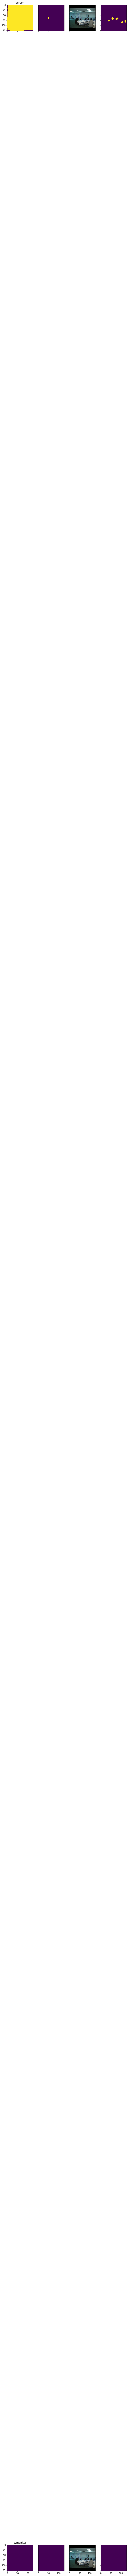

In [86]:
#labels_mask = labels_mask.to(device)
f, plots = plt.subplots(n_class, 4 , sharex='all', sharey='all', figsize=(1 * 10, 40 * 10))
for i in range(n_class):
   # plt.figure()
    plots[i,0].title.set_text(class_name[i+1])
    plots[i,0].imshow(pred_masks[0,i])
    plots[i,1].imshow(labels_center[0,i])
    plots[i,2].imshow(img)
    #plots[i,1].imshow(labels_center[0,i])
    #plots[2,i].imshow(labels_width[0,i])
    #plots[i,1].imshow(img)
    #plots[i,3].imshow(pred_centers[0,i])
    xx = pred_centers[0,i]
    xx[xx>0] = 1
    xx[xx<0] = 0
    plots[i,3].imshow(xx)

    #plots[5,i].imshow(pred_widths[0,i])
    

    

    


In [37]:
Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'test')
dataset.run_eval(results, opt.save_dir)
#len(results)

KeyError: 'test'

In [44]:
labels_center[0,0].min()


tensor(0, device='cuda:0', dtype=torch.uint8)

In [ ]:
np.sort(pred_centers[-1,...][4].ravel())

In [ ]:
#plt.imshow(pred_masks[0].transpose((1, 2, 0)))
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 3
n_class=3
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)
batch  = next(iter(val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']

k =1
plt.imshow(pred_masks[0,k])

In [39]:
#class_name = ['__background__',  "person",  "tvmonitor"]
class_name = ['__background__', "square", "circle", "triangle", "hexagon", "eclipse"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Dataset = get_dataset(opt.dataset, opt.task)
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)


==> initializing shapes train data.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded train 800 samples


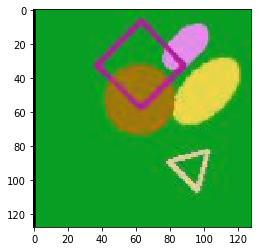

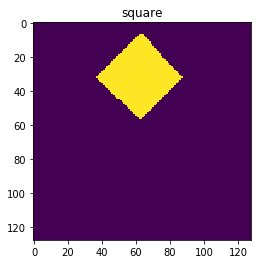

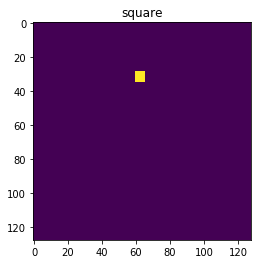

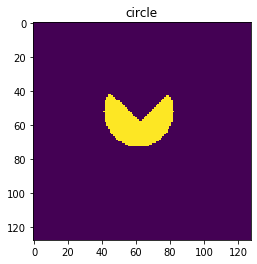

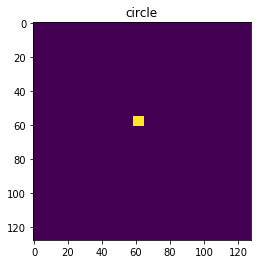

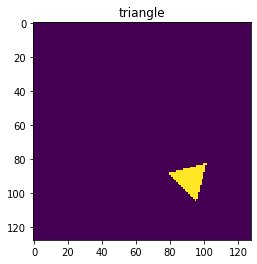

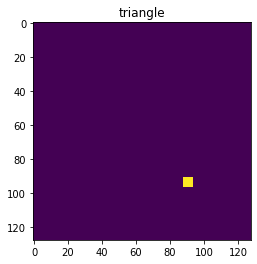

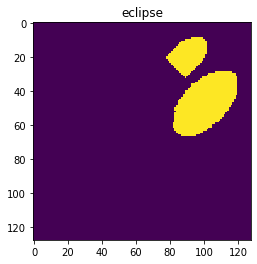

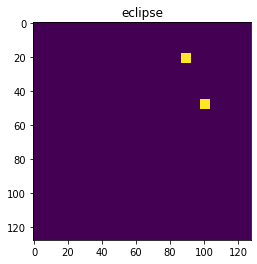

In [46]:
opt = opts()
opt.dataset = 'shape'
opt.epochs =  1000
opt.gamma = 0 # focal loss
opt.resume = False
opt.checkpoint_interval = 5
opt.scale =0.1# no effect
opt.shift =0.025# no effect
opt.flip =0.2# 0.5  
opt.update()
#img_id, org_img,ret


#for i in range(10):
d,batch  = next(iter(val_loader))
#plt.figure()
#plt.imshow(b[0].cpu().numpy().transpose(1,2,0)/256)
#import pdb;
#pdb.set_trace()
#batch = batch[1]
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height = batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
plt.figure()
#import pdb
#pdb.set_trace()
a = inputs[0]#.detach().cpu()#.numpy()
#print(a.shape)
plt.imshow(a.cpu().numpy().transpose(1,2,0)/256)   # way 1
# aa = a.transpose(0,2)     # way 2
# plt.imshow(aa.transpose(0,1)/256)
# a.reshape(255,255,3)
# a = a.resize(256,256,3)
# plt.imshow(a/256)
for i in range(5):
   if labels_mask[0,i].max() > 0:
       plt.figure()
       plt.imshow(labels_mask[0,i])
       plt.title(class_name[i+1])
       plt.figure()
       plt.imshow(labels_center[0,i])
       plt.title(class_name[i+1])
       

In [132]:
k=3
plt.imshow(labels_height[0,k])


IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
k = 3
plt.imshow(labels_width[0,k])

In [ ]:
k = 4
plt.imshow(labels_center[0,k])

In [ ]:
plt.figure()
#plt.imshow(reverse_transform(inputs[0].cpu()))
#plt.imshow(reverse_transform(labels_mask[0].cpu()))
#plt.imshow(reverse_transform(labels_center[0].cpu()))
#plt.imshow(reverse_transform(labels_width[0].cpu()))
#plt.imshow(reverse_transform(labels_height[0].cpu()))
plt.imshow(inputs[0].cpu().numpy().transpose((1, 2, 0))/255) #.dtype

In [ ]:
k = 4
plt.imshow(pred_widths[0,k])

In [ ]:
l.shape

In [9]:
valid_ids = np.arange(1, 3, dtype=np.int32)
cat_ids = {v: i for i, v in enumerate(valid_ids)}

In [52]:
#import sklearn
import numpy as np
from sklearn.cluster import MeanShift
X = np.array([[1, 1], [2, 1], [1, 0],[4, 7], [3, 5], [3, 6]])
clustering = MeanShift().fit(X) #bandwidth=0.5
clustering.labels_
#clustering.predict([[0, 0], [5, 5]])

array([4, 3, 5, 0, 2, 1])

In [94]:

import torch.nn as nn
import torch.nn.functional as F
conv = nn.Conv2d(..., bias=False)
with torch.no_grad():
    conv.weight = gaussian_weights
nb_channels = 1
h, w = 7, 7
x = torch.randn(1,1,h, w)
weights = torch.tensor([[-1., -1, -1],
                        [-1, 1., -1],
                        [-1, -1, -1]])
weights = weights.view(1,1, 3, 3).repeat(1,1,1,1)
output = F.conv2d(x, weights,padding=1)

In [99]:
output.shape




torch.Size([1, 1, 7, 7])

In [103]:
(output != 0).nonzero().size()

49

In [122]:
(output != 0).nonzero()[4][2]

tensor(0)

In [121]:

import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        
        return self.conv(input, weight=self.weight, groups=self.groups)

device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')  
smoothing = GaussianSmoothing(1, 7, 1).to(device)
input = torch.rand(1, 1, 100, 100)
input = input.type(torch.cuda.FloatTensor)  
input_2 = F.pad(input, (3, 3, 3, 3), mode='reflect')
output = smoothing(input_2)